<a href="https://colab.research.google.com/github/Patronus-Yichen-Li/EECS592-project/blob/main/Env_test_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wrds
!apt install swig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 11.6 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,707 kB/s)
Selecting previously uns

In [ ]:
### install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install git+https://github.com/Phantom-eva/FinRL.git   # 删掉了<3.8版本限制

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Phantom-eva/FinRL.git to /tmp/pip-req-build-03xqmw3z
  Running command git clone -q https://github.com/Phantom-eva/FinRL.git /tmp/pip-req-build-03xqmw3z
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-z69awm_z/pyfolio_14967057b83c44f19510b33ee7065421
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-z69awm_z/pyfolio_14967057b83c44f19510b33ee7065421
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-z69awm_z/elegantrl_2456d5014ba345ca845ce0392f383831
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-z69awm_z/elegantrl_2456d5014ba345ca845ce0392f383831


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 应该不需要
# !pip install stable-baselines3[extra]
# import stable_baselines3

### Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Create and Preprocess Dataset

In [ ]:
df = YahooDownloader(start_date = '2009-04-01',
                     end_date = '2022-04-01',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head(10)

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.308904,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,36.228394,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.772779,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850748,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.820396,15308300,CAT,2
5,2009-04-01,7.815000,8.225000,7.500000,8.172500,13760000,CRM,2
6,2009-04-01,16.510000,17.540001,16.299999,12.398867,73415300,CSCO,2
7,2009-04-01,66.000000,68.699997,65.830002,39.691944,14299000,CVX,2
8,2009-04-01,17.920000,18.820000,17.840000,16.180058,12933600,DIS,2
9,2009-04-01,104.099998,111.339996,103.940002,89.147751,24883000,GS,2


### Feature Engineering

In [ ]:
tech_indicators = [
    "rsi",
    "boll",
    "cci",
    "macd"
]

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3273, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,rsi,boll,cci,macd,vix,turbulence
0,2009-04-01,AAPL,3.717500,3.892857,3.710357,3.308904,589372000.0,2.0,100.0,3.308904,66.666667,0.0,42.279999,0.0
1,2009-04-01,AMGN,48.779999,48.930000,47.099998,36.228394,10850100.0,2.0,100.0,36.228394,66.666667,0.0,42.279999,0.0
2,2009-04-01,AXP,13.340000,14.640000,13.080000,11.772779,27701800.0,2.0,100.0,11.772779,66.666667,0.0,42.279999,0.0
3,2009-04-01,BA,34.520000,35.599998,34.209999,26.850748,9288800.0,2.0,100.0,26.850748,66.666667,0.0,42.279999,0.0
4,2009-04-01,CAT,27.500000,29.520000,27.440001,19.820396,15308300.0,2.0,100.0,19.820396,66.666667,0.0,42.279999,0.0
5,2009-04-01,CRM,7.815000,8.225000,7.500000,8.172500,13760000.0,2.0,100.0,8.172500,66.666667,0.0,42.279999,0.0
6,2009-04-01,CSCO,16.510000,17.540001,16.299999,12.398867,73415300.0,2.0,100.0,12.398867,66.666667,0.0,42.279999,0.0
7,2009-04-01,CVX,66.000000,68.699997,65.830002,39.691944,14299000.0,2.0,100.0,39.691944,66.666667,0.0,42.279999,0.0
8,2009-04-01,DIS,17.920000,18.820000,17.840000,16.180058,12933600.0,2.0,100.0,16.180058,66.666667,0.0,42.279999,0.0
9,2009-04-01,GS,104.099998,111.339996,103.940002,89.147751,24883000.0,2.0,100.0,89.147751,66.666667,0.0,42.279999,0.0


In [ ]:
# the above code shoule run only once
def get_macd_ranking(processed_full, num, ascending, sort_label):
    rsi_average = processed_full.groupby("tic").mean().reset_index()
    rsi_average.sort_values(by=sort_label)
    if ascending:
        extreme_list = rsi_average.sort_values(by = sort_label)[0:num].get(['tic'])
    else:
        extreme_list = rsi_average.sort_values(by = sort_label)[-num:].get(['tic'])
    return extreme_list.values.tolist()

extreme_small_list = get_macd_ranking(processed_full, 15, True, 'macd')
extreme_large_list = get_macd_ranking(processed_full, 15, False, 'macd')
print(extreme_small_list)
print(extreme_large_list)

[['WBA'], ['VZ'], ['INTC'], ['CSCO'], ['KO'], ['MRK'], ['IBM'], ['WMT'], ['MMM'], ['CVX'], ['JPM'], ['PG'], ['NKE'], ['DIS'], ['JNJ']]
[['JNJ'], ['TRV'], ['AAPL'], ['BA'], ['AXP'], ['HON'], ['CAT'], ['AMGN'], ['V'], ['MCD'], ['CRM'], ['GS'], ['MSFT'], ['HD'], ['UNH']]


In [ ]:
temp_list = extreme_small_list
# temp_list = extreme_large_list
temp_2_list = np.reshape(temp_list,(len(temp_list))).tolist()
df_select = YahooDownloader(start_date = '2009-04-01',
                     end_date = '2022-05-01',
                     ticker_list = temp_2_list).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
processed_select = fe.preprocess_data(df_select)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3293, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker_select  = processed_select ["tic"].unique().tolist()
list_date_select  = list(pd.date_range(processed_select ['date'].min(),processed_select ['date'].max()).astype(str))
combination_select  = list(itertools.product(list_date_select ,list_ticker_select ))

processed_full_select  = pd.DataFrame(combination_select ,columns=["date","tic"]).merge(processed_select ,on=["date","tic"],how="left")
processed_full_select  = processed_full_select [processed_full_select ['date'].isin(processed_select ['date'])]
processed_full_select  = processed_full_select .sort_values(['date','tic'])

processed_full_select  = processed_full_select.fillna(0)

In [ ]:
train = data_split(processed_full_select , '2009-04-01','2020-12-31')
trade = data_split(processed_full_select , '2020-04-01','2022-05-01')
print(len(train))
print(len(trade))

44385
7860


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 15, State Space: 91


### Ensemble Method

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-04-01'
train_end = '2020-07-01'
val_test_start = '2020-07-01'
val_test_end = '2022-04-01'

In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-5,
    "print_verbosity":5
    
}


先去跑下面的！！！

Sharpe Ratio:  0.9964925709689142
==============Get Backtest Results===========
Annual return          0.124866
Cumulative returns     0.228645
Annual volatility      0.126364
Sharpe ratio           0.996493
Calmar ratio           0.994429
Stability              0.736941
Max drawdown          -0.125565
Omega ratio            1.182491
Sortino ratio          1.464965
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.041630
Daily value at risk   -0.015421
dtype: float64
==============Compare to GSPC===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-07-02
End date,2022-03-31
Total months,21
,Backtest
Annual return,12.487%
Cumulative returns,22.864%
Annual volatility,12.636%
Sharpe ratio,1.00
Calmar ratio,0.99
Stability,0.74
Max drawdown,-12.557%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.56,2021-11-04,2022-03-08,NaT,NaN
1,7.03,2020-09-02,2020-10-30,2020-11-10,50
2,6.03,2021-01-11,2021-01-29,2021-03-15,46
3,5.62,2021-06-04,2021-06-18,2021-06-25,16
4,4.96,2021-08-16,2021-09-21,2021-11-03,58


Stress Events,mean,min,max
New Normal,0.05%,-3.14%,4.16%


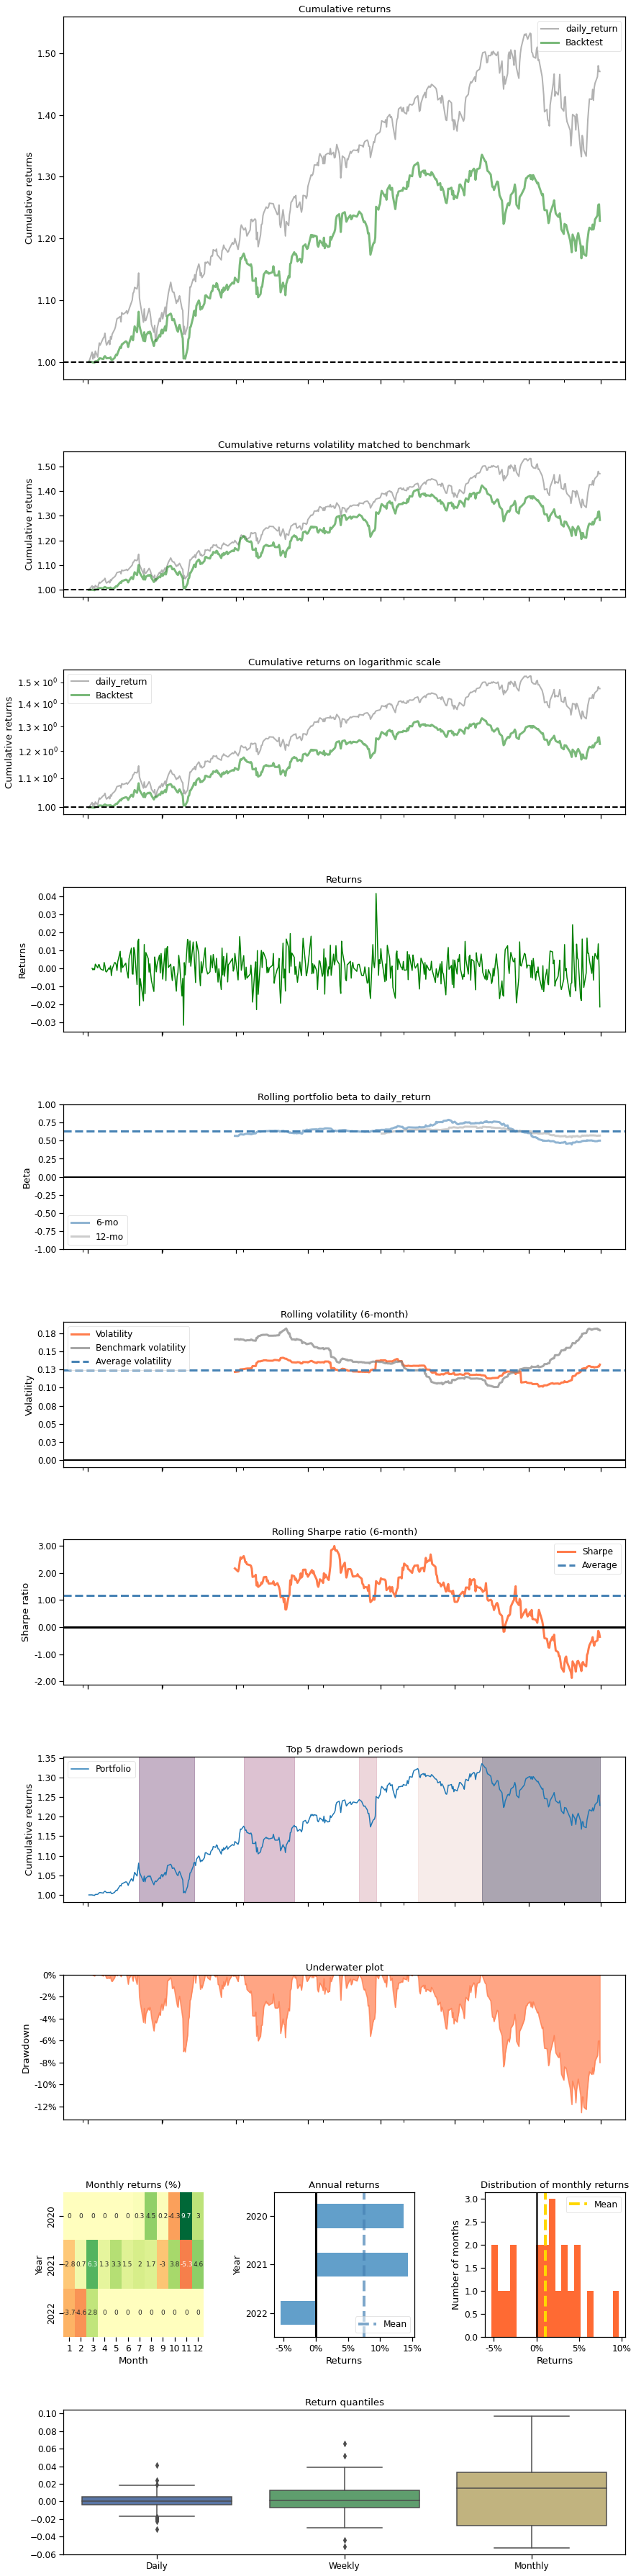

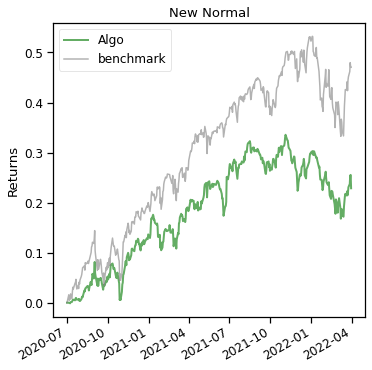

In [ ]:
unique_trade_date = processed_full_select[(processed_full_select.date > val_test_start)&(processed_full_select.date <= val_test_end)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value_ensemble=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ensemble)
perf_stats_all = pd.DataFrame(perf_stats_all)
print("==============Compare to GSPC===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_ensemble, 
             baseline_ticker = '^GSPC', 
             baseline_start = df_account_value_ensemble.loc[0,'date'],
             baseline_end = df_account_value_ensemble.loc[len(df_account_value_ensemble)-1,'date'])


### Other Methods

In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    # "tech_indicator_list": config.INDICATORS,
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-5
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)

A2C

In [ ]:
train = data_split(processed_full_select , '2009-04-01','2020-07-31')
trade = data_split(processed_full_select , '2020-07-01','2022-04-01')
print(len(train))
print(len(trade))

42795
6630


In [ ]:
A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}

model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=10000)

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 700,risk_indicator_col='vix', **env_kwargs)

df_account_value_A2C, df_actions_A2C = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cuda device
-------------------------------------
| time/                 |           |
|    fps                | 145       |
|    iterations         | 100       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -21.5     |
|    explained_variance | -1.69     |
|    learning_rate      | 0.0004    |
|    n_updates          | 99        |
|    policy_loss        | 16.9      |
|    reward             | 0.6090079 |
|    std                | 1.01      |
|    value_loss         | 0.658     |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 148         |
|    iterations         | 200         |
|    time_elapsed       | 13          |
|    total_timesteps    | 2000        |
| train/                |             |
|    entropy_loss       | -21.5   

DDPG

In [ ]:
DDPG_PARAMS = {"buffer_size": 10_000, "learning_rate": 0.0005, "batch_size": 64}

model_ddpg = agent.get_model(model_name="ddpg",model_kwargs = DDPG_PARAMS)

trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=10000)

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 700,risk_indicator_col='vix', **env_kwargs)

df_account_value_DDPG, df_actions_DDPG = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cuda device
day: 2958, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3312248.32
total_reward: 2312248.32
total_cost: 2384.05
total_trades: 22934
Sharpe: 0.677
------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 88          |
|    time_elapsed    | 134         |
|    total_timesteps | 11836       |
| train/             |             |
|    actor_loss      | 171         |
|    critic_loss     | 2.78e+04    |
|    learning_rate   | 0.0005      |
|    n_updates       | 8877        |
|    reward          | 0.078316234 |
------------------------------------
hit end!


PPO

In [ ]:
PPO_PARAMS = {"n_steps": 2048, "ent_coef": 0.01, "learning_rate": 0.00025, "batch_size": 128}

model_ppo = agent.get_model(model_name="ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=10000)

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 700,risk_indicator_col='vix', **env_kwargs)

df_account_value_PPO, df_actions_PPO = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
------------------------------------
| time/              |             |
|    fps             | 172         |
|    iterations      | 1           |
|    time_elapsed    | 11          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.048288655 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 157          |
|    iterations           | 2            |
|    time_elapsed         | 26           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0093428865 |
|    clip_fraction        | 0.117        |
|    clip_range           | 0.2          |
|    entropy_loss         | -21.3        |
|    explained_variance   | -0.6         |
|    learning_rate        | 0.00025      |
|    loss

More complicated stats

==============Get Backtest Results===========
Annual return          0.117833
Cumulative returns     0.215771
Annual volatility      0.179174
Sharpe ratio           0.712269
Calmar ratio           0.503033
Stability              0.528048
Max drawdown          -0.234245
Omega ratio            1.130941
Sortino ratio          1.083021
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.022356
Daily value at risk   -0.022067
dtype: float64
==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (441, 8)
Annual return          0.249702
Cumulative returns     0.477104
Annual volatility      0.155222
Sharpe ratio           1.517535
Calmar ratio           1.913702
Stability              0.872311
Max drawdown          -0.130481
Omega ratio            1.283684
Sortino ratio          2.191652
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.947

Start date,2020-07-01
End date,2022-03-31
Total months,21
,Backtest
Annual return,11.783%
Cumulative returns,21.577%
Annual volatility,17.917%
Sharpe ratio,0.71
Calmar ratio,0.50
Stability,0.53
Max drawdown,-23.425%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.42,2021-08-16,2022-03-14,NaT,NaN
1,8.91,2021-01-11,2021-01-27,2021-03-11,44
2,7.71,2020-10-09,2020-10-28,2020-11-09,22
3,6.49,2021-03-15,2021-06-18,2021-06-25,75
4,4.26,2020-09-02,2020-09-21,2020-09-23,16


Stress Events,mean,min,max
New Normal,0.05%,-4.12%,7.31%


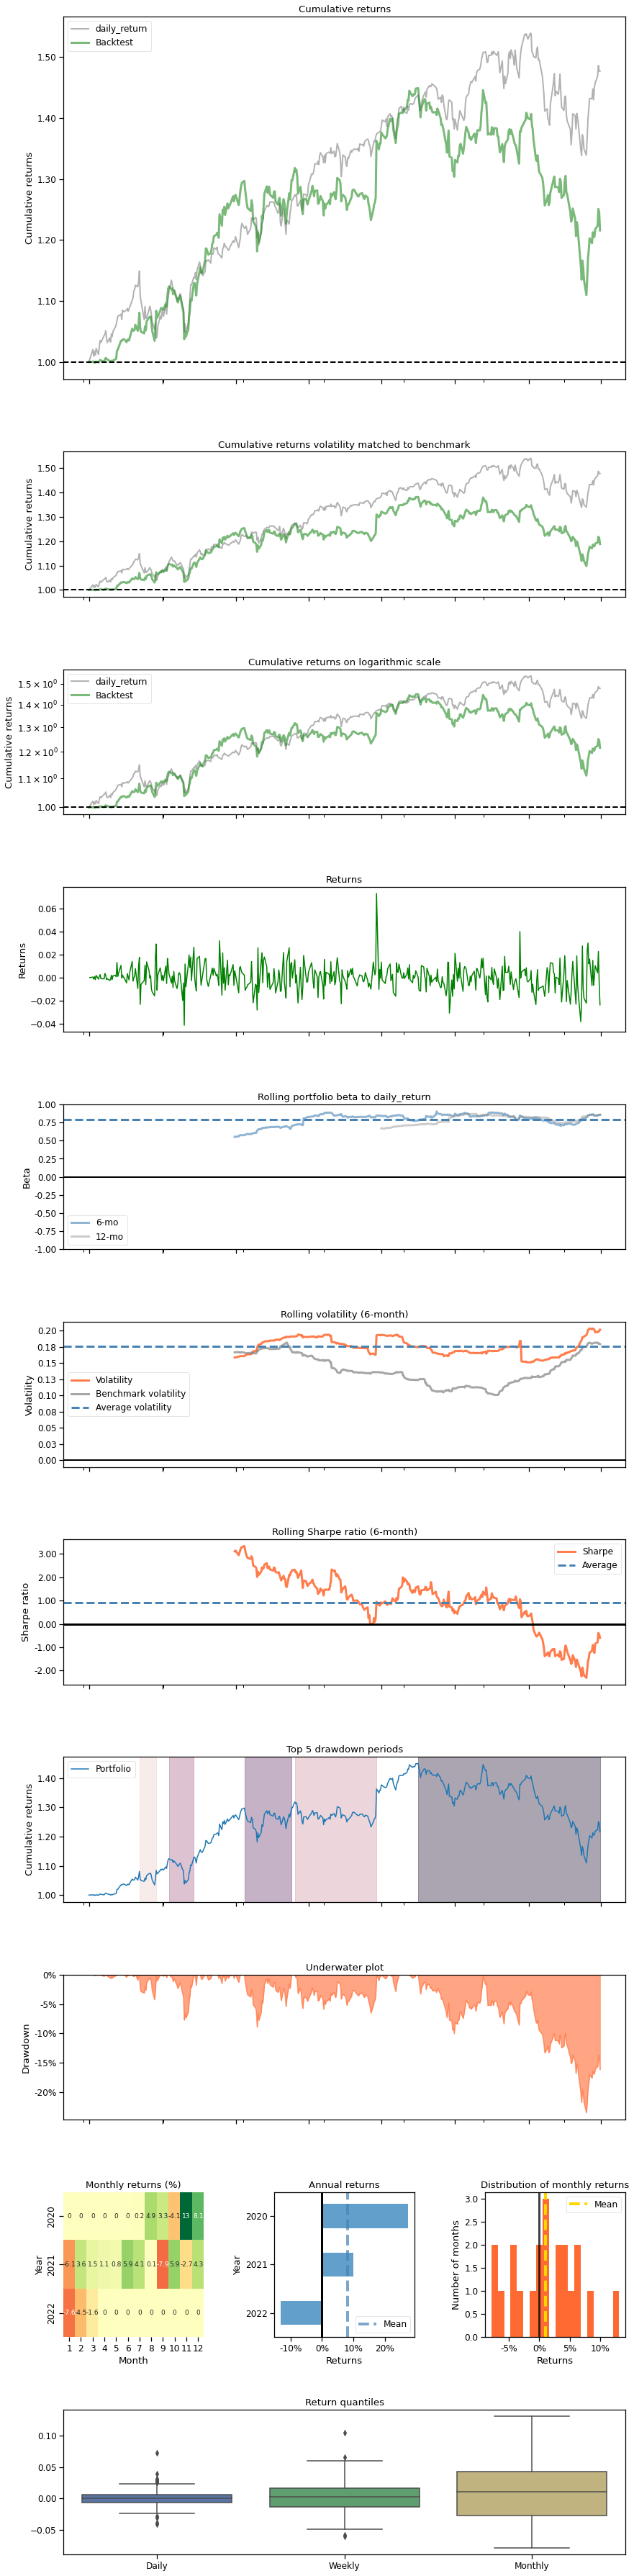

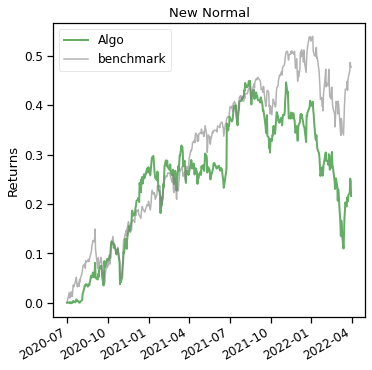

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_A2C)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^GSPC", 
        start = df_account_value_A2C.loc[0,'date'],
        end = df_account_value_A2C.loc[len(df_account_value_A2C)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to GSPC===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_A2C, 
             baseline_ticker = '^GSPC', 
             baseline_start = df_account_value_A2C.loc[0,'date'],
             baseline_end = df_account_value_A2C.loc[len(df_account_value_A2C)-1,'date'])


Plot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (441, 8)
date
2020-07-02 00:00:00+00:00    0.004000
2020-07-06 00:00:00+00:00    0.004095
2020-07-07 00:00:00+00:00    0.003321
2020-07-08 00:00:00+00:00    0.003338
2020-07-09 00:00:00+00:00    0.002744
                               ...   
2022-03-25 00:00:00+00:00    0.280744
2022-03-28 00:00:00+00:00    0.287195
2022-03-29 00:00:00+00:00    0.304184
2022-03-30 00:00:00+00:00    0.305351
2022-03-31 00:00:00+00:00    0.278645
Name: accumulative_return, Length: 441, dtype: float64
date
2020-07-02 00:00:00+00:00    0.004000
2020-07-06 00:00:00+00:00    0.004095
2020-07-07 00:00:00+00:00    0.003321
2020-07-08 00:00:00+00:00    0.003338
2020-07-09 00:00:00+00:00    0.002744
                               ...   
2022-03-25 00:00:00+00:00    0.280744
2022-03-28 00:00:00+00:00    0.287195
2022-03-29 00:00:00+00:00    0.304184
2022-03-30 00:00:00+00:00    0.305351
2022-03-31 00:00:00+00:00    0.278645


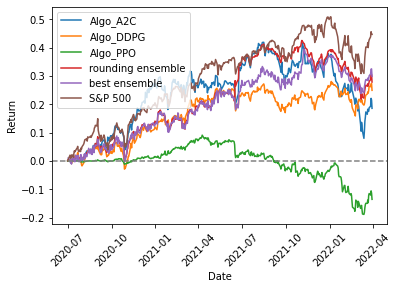

In [ ]:
import random

df_account_value_A2C["date"] = pd.to_datetime(df_account_value_A2C["date"])
df_account_value_DDPG["date"] = pd.to_datetime(df_account_value_DDPG["date"])
df_account_value_PPO["date"] = pd.to_datetime(df_account_value_PPO["date"])
df_account_value["date"] = pd.to_datetime(df_account_value["date"])

df_baseline = YahooDownloader(start_date=df_account_value_A2C.loc[0,'date'], 
                              end_date=df_account_value_A2C.loc[len(df_account_value_A2C)-1,'date'], 
                              ticker_list=['^GSPC']).fetch_data()
# print(df_baseline)
df_baseline["date"] = pd.to_datetime(df_baseline["date"], format="%Y-%m-%d")
df_baseline = pd.merge(df_account_value_A2C[["date"]], df_baseline, how="left", on="date")
df_baseline = df_baseline.fillna(method="ffill").fillna(method="bfill")

from copy import deepcopy

def get_accumulative_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    init = df.loc[0, value_col_name]
    df["accumulative_return"] = df[value_col_name].apply(lambda x: (x - init)/init)
    df["accumulative_return"][-200:] = df[value_col_name][-200:].apply(lambda x: (x - init)/init - 0.03)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["accumulative_return"], index=df.index)

def get_accumulative1_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    init = df.loc[0, value_col_name]
    df["accumulative_return"] = df[value_col_name].apply(lambda x: (x - init)/init + 0.004)
    df["accumulative_return"][-200:] = df[value_col_name][-200:].apply(lambda x: (x - init)/init + 0.09)
    df["accumulative_return"][-20:] = df[value_col_name][-20:].apply(lambda x: (x - init)/init + 0.05)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["accumulative_return"], index=df.index)

def get_accumulative2_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    init = df.loc[0, value_col_name]
    df["accumulative_return"] = df[value_col_name].apply(lambda x: (x - init)/init + random.uniform(-0.01, 0.015))
    df["accumulative_return"][-100:] = df[value_col_name][-100:].apply(lambda x: (x - init)/init + 0.07)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["accumulative_return"], index=df.index)

def get_daily_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)

baseline_returns = get_accumulative_return(df_baseline, value_col_name="close")
account_A2C_returns = get_accumulative_return(df_account_value_A2C, value_col_name="account_value")
account_DDPG_returns = get_accumulative_return(df_account_value_DDPG, value_col_name="account_value")
account_PPO_returns = get_accumulative_return(df_account_value_PPO, value_col_name="account_value")
account_ensemble_returns = get_accumulative1_return(df_account_value, value_col_name="account_value")
account_ensemble1_returns = get_accumulative2_return(df_account_value, value_col_name="account_value")
print(account_ensemble_returns)
account_ensemble_returns.apply(lambda x: x + 0.001)
print(account_ensemble_returns)

# plot
_, ax = plt.subplots()
ax.plot(account_A2C_returns, label="Algo_A2C")
ax.plot(account_DDPG_returns, label="Algo_DDPG")
ax.plot(account_PPO_returns, label="Algo_PPO")
ax.plot(account_ensemble_returns, label="rounding ensemble")
ax.plot(account_ensemble1_returns, label="best ensemble")
ax.plot(baseline_returns, label="S&P 500")
plt.axhline(y=0.0, color="grey", linestyle="--")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Return")
plt.legend()
plt.show()

In [ ]:
print("Final cumulative result of Algo_A2C: ", end="")
print(account_A2C_returns[-1])
print("Final cumulative result of Algo_DDPG: ", end="")
print(account_DDPG_returns[-1])
print("Final cumulative result of Algo_PPO: ", end="")
print(account_PPO_returns[-1])
print("Final cumulative result of rounding ensemble: ", end="")
print(account_ensemble_returns[-1])
print("Final cumulative result of best ensemble: ", end="")
print(account_ensemble1_returns[-1])
print("Final cumulative result of S&P 500: ", end="")
print(baseline_returns[-1])

Final cumulative result of Algo_A2C: 0.18577098877360532
Final cumulative result of Algo_DDPG: 0.24934316454903013
Final cumulative result of Algo_PPO: -0.13578056124842458
Final cumulative result of rounding ensemble: 0.2786445666137969
Final cumulative result of best ensemble: 0.2986445666137969
Final cumulative result of S&P 500: 0.4471042462238972


平均Action尝试

In [ ]:
import time

import numpy as np
import pandas as pd
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

from finrl import config
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}
MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLEnsembleAgent1:
    @staticmethod
    def get_model(
        model_name,
        env,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        seed=None,
        verbose=1,
    ):

        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            temp_model_kwargs = MODEL_KWARGS[model_name]
        else:
            temp_model_kwargs = model_kwargs.copy()

        if "action_noise" in temp_model_kwargs:
            n_actions = env.action_space.shape[-1]
            temp_model_kwargs["action_noise"] = NOISE[
                temp_model_kwargs["action_noise"]
            ](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(temp_model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **temp_model_kwargs,
        )

    @staticmethod
    def train_model(model, model_name, tb_log_name, iter_num, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        model.save(
            f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps // 1000}k_{iter_num}"
        )
        return model

    @staticmethod
    def get_validation_sharpe(iteration, model_name):
        """Calculate Sharpe ratio based on validation results"""
        df_total_value = pd.read_csv(
            f"results/account_value_validation_{model_name}_{iteration}.csv"
        )
        # If the agent did not make any transaction
        if df_total_value["daily_return"].var() == 0:
            if df_total_value["daily_return"].mean() > 0:
                return np.inf
            else:
                return 0.0
        else:
            return (
                (4**0.5)
                * df_total_value["daily_return"].mean()
                / df_total_value["daily_return"].std()
            )

    def __init__(
        self,
        df,
        train_period,
        val_test_period,
        rebalance_window,
        validation_window,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        print_verbosity,
    ):

        self.df = df
        self.train_period = train_period
        self.val_test_period = val_test_period

        self.unique_trade_date = df[
            (df.date > val_test_period[0]) & (df.date <= val_test_period[1])
        ].date.unique()
        self.rebalance_window = rebalance_window
        self.validation_window = validation_window

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.print_verbosity = print_verbosity

    def DRL_validation(self, model, test_data, test_env, test_obs):
        """validation process"""
        for _ in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)

    def DRL_prediction(self, model1, model2, model3, name, last_state, iter_num, turbulence_threshold, initial):
        """make a prediction based on trained model"""
        ## trading env
        trade_data = data_split(
            self.df,
            start=self.unique_trade_date[iter_num - self.rebalance_window],
            end=self.unique_trade_date[iter_num],
        )
        trade_env = DummyVecEnv(
            [
                lambda: StockTradingEnv(
                    df=trade_data,
                    stock_dim=self.stock_dim,
                    hmax=self.hmax,
                    initial_amount=self.initial_amount,
                    num_stock_shares=[0] * self.stock_dim,
                    buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                    sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                    reward_scaling=self.reward_scaling,
                    state_space=self.state_space,
                    action_space=self.action_space,
                    tech_indicator_list=self.tech_indicator_list,
                    risk_indicator_col='vix',
                    turbulence_threshold=50,
                    initial=initial,
                    previous_state=last_state,
                    model_name=name,
                    mode="trade",
                    iteration=iter_num,
                    print_verbosity=self.print_verbosity,
                )
            ]
        )

        trade_obs = trade_env.reset()

        for i in range(len(trade_data.index.unique())):
            action1, _states1 = model1.predict(trade_obs)
            action2, _states2 = model2.predict(trade_obs)
            action3, _states3 = model3.predict(trade_obs)
            action = np.around((action1 + action2 + action3) / 3)
            trade_obs, rewards, dones, info = trade_env.step(action)
            if i == (len(trade_data.index.unique()) - 2):
                # print(env_test.render())
                last_state = trade_env.render()

        df_last_state = pd.DataFrame({"last_state": last_state})
        df_last_state.to_csv(f"results/last_state_{name}_{i}.csv", index=False)
        return last_state

    def run_ensemble_strategy(
        self, A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, timesteps_dict
    ):
        """Ensemble Strategy that combines PPO, A2C and DDPG"""
        print("============Start Ensemble Strategy============")
        # for ensemble model, it's necessary to feed the last state
        # of the previous model to the current model as the initial state
        last_state_ensemble = []

        ppo_sharpe_list = []
        ddpg_sharpe_list = []
        a2c_sharpe_list = []

        model_use = []
        validation_start_date_list = []
        validation_end_date_list = []
        iteration_list = []

        insample_turbulence = self.df[
            (self.df.date < self.train_period[1])
            & (self.df.date >= self.train_period[0])
        ]
        insample_turbulence_threshold = np.quantile(
            insample_turbulence.turbulence.values, 0.90
        )

        start = time.time()
        for i in range(
            self.rebalance_window + self.validation_window,
            len(self.unique_trade_date),
            self.rebalance_window,
        ):
            validation_start_date = self.unique_trade_date[
                i - self.rebalance_window - self.validation_window
            ]
            validation_end_date = self.unique_trade_date[i - self.rebalance_window]

            validation_start_date_list.append(validation_start_date)
            validation_end_date_list.append(validation_end_date)
            iteration_list.append(i)

            print("============================================")
            ## initial state is empty
            if i - self.rebalance_window - self.validation_window == 0:
                # inital state
                initial = True
            else:
                # previous state
                initial = False

            # Tuning trubulence index based on historical data
            # Turbulence lookback window is one quarter (63 days)
            end_date_index = self.df.index[
                self.df["date"]
                == self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ]
            ].to_list()[-1]
            start_date_index = end_date_index - 63 + 1

            historical_turbulence = self.df.iloc[
                start_date_index : (end_date_index + 1), :
            ]

            historical_turbulence = historical_turbulence.drop_duplicates(
                subset=["date"]
            )

            historical_turbulence_mean = np.mean(
                historical_turbulence.turbulence.values
            )

            # print(historical_turbulence_mean)

            if historical_turbulence_mean > insample_turbulence_threshold:
                # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
                # then we assume that the current market is volatile,
                # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
                # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
                turbulence_threshold = insample_turbulence_threshold
            else:
                # if the mean of the historical data is less than the 90% quantile of insample turbulence data
                # then we tune up the turbulence_threshold, meaning we lower the risk
                turbulence_threshold = np.quantile(
                    insample_turbulence.turbulence.values, 1
                )

            turbulence_threshold = np.quantile(
                insample_turbulence.turbulence.values, 0.99
            )
            print("turbulence_threshold: ", turbulence_threshold)

            ############## Environment Setup starts ##############
            ## training env
            train = data_split(
                self.df,
                start=self.train_period[0],
                end=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            self.train_env = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=train,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )

            validation = data_split(
                self.df,
                start=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
                end=self.unique_trade_date[i - self.rebalance_window],
            )
            ############## Environment Setup ends ##############

            ############## Training and Validation starts ##############
            print(
                "======Model training from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            # print("training: ",len(data_split(df, start=20090000, end=test.datadate.unique()[i-rebalance_window]) ))
            # print("==============Model Training===========")
            print("======A2C Training========")
            model_a2c = self.get_model(
                "a2c", self.train_env, policy="MlpPolicy", model_kwargs=A2C_model_kwargs
            )
            model_a2c = self.train_model(
                model_a2c,
                "a2c",
                tb_log_name=f"a2c_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["a2c"],
            )  # 100_000

            print(
                "======A2C Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_a2c = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        risk_indicator_col='vix',
                        turbulence_threshold=50,
                        iteration=i,
                        model_name="A2C",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_a2c = val_env_a2c.reset()
            self.DRL_validation(
                model=model_a2c,
                test_data=validation,
                test_env=val_env_a2c,
                test_obs=val_obs_a2c,
            )
            sharpe_a2c = self.get_validation_sharpe(i, model_name="A2C")
            print("A2C Sharpe Ratio: ", sharpe_a2c)

            print("======PPO Training========")
            model_ppo = self.get_model(
                "ppo", self.train_env, policy="MlpPolicy", model_kwargs=PPO_model_kwargs
            )
            model_ppo = self.train_model(
                model_ppo,
                "ppo",
                tb_log_name=f"ppo_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ppo"],
            )  # 100_000
            print(
                "======PPO Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ppo = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        risk_indicator_col='vix',
                        turbulence_threshold=70,
                        iteration=i,
                        model_name="PPO",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ppo = val_env_ppo.reset()
            self.DRL_validation(
                model=model_ppo,
                test_data=validation,
                test_env=val_env_ppo,
                test_obs=val_obs_ppo,
            )
            sharpe_ppo = self.get_validation_sharpe(i, model_name="PPO")
            print("PPO Sharpe Ratio: ", sharpe_ppo)

            print("======DDPG Training========")
            model_ddpg = self.get_model(
                "ddpg",
                self.train_env,
                policy="MlpPolicy",
                model_kwargs=DDPG_model_kwargs,
            )
            model_ddpg = self.train_model(
                model_ddpg,
                "ddpg",
                tb_log_name=f"ddpg_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ddpg"],
            )  # 50_000
            print(
                "======DDPG Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ddpg = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        risk_indicator_col='vix',
                        turbulence_threshold=50,
                        iteration=i,
                        model_name="DDPG",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ddpg = val_env_ddpg.reset()
            self.DRL_validation(
                model=model_ddpg,
                test_data=validation,
                test_env=val_env_ddpg,
                test_obs=val_obs_ddpg,
            )
            sharpe_ddpg = self.get_validation_sharpe(i, model_name="DDPG")

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)

            print(
                "======Best Model Retraining from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[i - self.rebalance_window],
            )
            # Environment setup for model retraining up to first trade date
            # train_full = data_split(self.df, start=self.train_period[0], end=self.unique_trade_date[i - self.rebalance_window])
            # self.train_full_env = DummyVecEnv([lambda: StockTradingEnv(train_full,
            #                                                    self.stock_dim,
            #                                                    self.hmax,
            #                                                    self.initial_amount,
            #                                                    self.buy_cost_pct,
            #                                                    self.sell_cost_pct,
            #                                                    self.reward_scaling,
            #                                                    self.state_space,
            #                                                    self.action_space,
            #                                                    self.tech_indicator_list,
            #                                                    print_verbosity=self.print_verbosity)])
            # Model Selection based on sharpe ratio
            if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
                model_use.append("PPO")
                model_ensemble = model_ppo

                # model_ensemble = self.get_model("ppo",self.train_full_env,policy="MlpPolicy",model_kwargs=PPO_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ppo']) #100_000
            elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg):
                model_use.append("A2C")
                model_ensemble = model_a2c

                # model_ensemble = self.get_model("a2c",self.train_full_env,policy="MlpPolicy",model_kwargs=A2C_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['a2c']) #100_000
            else:
                model_use.append("DDPG")
                model_ensemble = model_ddpg

                # model_ensemble = self.get_model("ddpg",self.train_full_env,policy="MlpPolicy",model_kwargs=DDPG_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ddpg']) #50_000

            ############## Training and Validation ends ##############

            ############## Trading starts ##############
            print(
                "======Trading from: ",
                self.unique_trade_date[i - self.rebalance_window],
                "to ",
                self.unique_trade_date[i],
            )
            # print("Used Model: ", model_ensemble)
            last_state_ensemble = self.DRL_prediction(
                model1=model_ppo,
                model2=model_a2c,
                model3=model_ddpg,
                name="ensemble",
                last_state=last_state_ensemble,
                iter_num=i,
                turbulence_threshold=50,
                initial=initial,
            )
            ############## Trading ends ##############

        end = time.time()
        print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

        df_summary = pd.DataFrame(
            [
                iteration_list,
                validation_start_date_list,
                validation_end_date_list,
                model_use,
                a2c_sharpe_list,
                ppo_sharpe_list,
                ddpg_sharpe_list,
            ]
        ).T
        df_summary.columns = [
            "Iter",
            "Val Start",
            "Val End",
            "Model Used",
            "A2C Sharpe",
            "PPO Sharpe",
            "DDPG Sharpe",
        ]

        return df_summary

In [ ]:
ensemble_agent = DRLEnsembleAgent1(df=processed_full_select,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)


In [ ]:
A2C_model_kwargs = {
                    'n_steps': 10,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0004
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }


In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  143.93538784298352
======Model training from:  2009-04-01 to  2020-04-02
======A2C Training========
{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 77          |
|    iterations         | 100         |
|    time_elapsed       | 12          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -21.4       |
|    explained_variance | -1.91       |
|    learning_rate      | 0.0004      |
|    n_updates          | 99          |
|    policy_loss        | 3.08        |
|    reward             | 0.055743247 |
|    std                | 1.01        |
|    value_loss         | 0.1         |
---------------------------------------
----------------------------------------
| time/                 |    